In [1]:
import os
import json
import numpy as np
import pandas as pd
import argparse
import random

from sklearn.model_selection import StratifiedGroupKFold
from tqdm import tqdm

from pycocotools.coco import COCO
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

data_path = "../../data/dataV2"

annotations_path = os.path.join(data_path, "merge_coco.json")
KFold_train_paths = [os.path.join(data_path,"stratified_group_kfold",  f"train_fold{k}.json") for k in range(5)]
KFold_val_paths = [os.path.join(data_path,"stratified_group_kfold",  f"val_fold{k}.json") for k in range(5)]

In [2]:
classes = [
    "General trash",
    "Paper",
    "Paper pack",
    "Metal",
    "Glass",
    "Plastic",
    "Styrofoam",
    "Plastic bag",
    "Battery",
    "Clothing",
]
palette = [
    [0, 0, 128],
    [0, 128, 192],
    [0, 128, 64],
    [128, 0, 0],
    [64, 0, 128],
    [64, 0, 192],
    [192, 128, 64],
    [192, 192, 128],
    [64, 64, 128],
    [128, 0, 192],
]
def get_mask(path):
    area_count = {}
    coco = COCO(path)
    catIds = coco.getCatIds()
    imgIds = coco.getImgIds()
    print("catIds len:{}, imgIds len:{}".format(len(catIds), len(imgIds)))
    for index, imgId in tqdm(enumerate(imgIds), total=len(imgIds)):
        img = coco.loadImgs(imgId)[0]
        annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        anns = sorted(anns, key=lambda idx: idx['area'], reverse=True)
        if len(annIds) > 0:
            mask = coco.annToMask(anns[0]) * anns[0]['category_id']
            for i in range(len(anns) - 1):
                mask[coco.annToMask(anns[i+1]) == 1] = anns[i+1]['category_id']
        
        class_dict = Counter(mask.flatten())
        for key, value in class_dict.items():
            if not key in area_count:
                area_count[key] = 0
            area_count[key] += value
    return area_count

In [3]:
## all_file class distribution
dic = get_mask(annotations_path)
dic_train = [get_mask(KFold_train_paths[i]) for i in range(5)]
dic_val = [get_mask(KFold_val_paths[i]) for i in range(5)]

loading annotations into memory...
Done (t=3.64s)
creating index...
index created!
catIds len:10, imgIds len:3272


100%|██████████| 3272/3272 [01:00<00:00, 53.97it/s]


loading annotations into memory...
Done (t=3.07s)
creating index...
index created!
catIds len:10, imgIds len:2619


100%|██████████| 2619/2619 [00:48<00:00, 53.86it/s]


loading annotations into memory...
Done (t=3.01s)
creating index...
index created!
catIds len:10, imgIds len:2617


100%|██████████| 2617/2617 [00:48<00:00, 54.27it/s]


loading annotations into memory...
Done (t=3.11s)
creating index...
index created!
catIds len:10, imgIds len:2617


100%|██████████| 2617/2617 [00:48<00:00, 53.85it/s]


loading annotations into memory...
Done (t=3.04s)
creating index...
index created!
catIds len:10, imgIds len:2618


100%|██████████| 2618/2618 [00:48<00:00, 53.73it/s]


loading annotations into memory...
Done (t=2.94s)
creating index...
index created!
catIds len:10, imgIds len:2617


100%|██████████| 2617/2617 [00:48<00:00, 53.59it/s]


loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
catIds len:10, imgIds len:653


100%|██████████| 653/653 [00:12<00:00, 54.31it/s]


loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
catIds len:10, imgIds len:655


100%|██████████| 655/655 [00:12<00:00, 53.45it/s]


loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
catIds len:10, imgIds len:655


100%|██████████| 655/655 [00:12<00:00, 53.73it/s]


loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
catIds len:10, imgIds len:654


100%|██████████| 654/654 [00:12<00:00, 53.88it/s]


loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
catIds len:10, imgIds len:655


100%|██████████| 655/655 [00:12<00:00, 53.63it/s]


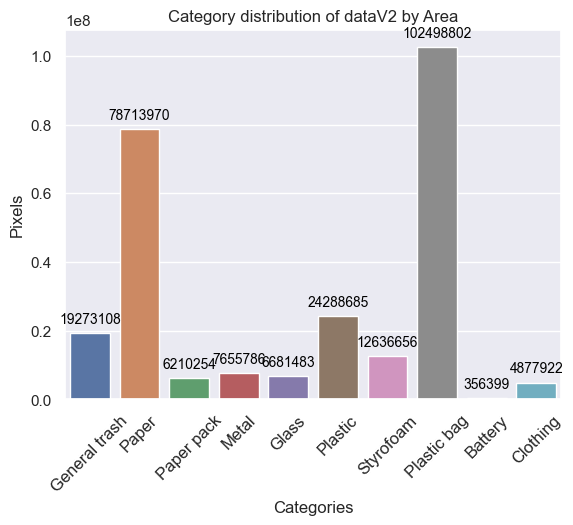

In [27]:
sorted_dict = sorted(dic.items())
t_pixels = []
for i, pixel in sorted_dict:
    if i == 0:
        continue
    t_pixels.append(pixel)
plt.title("Category distribution of dataV2 by Area")
df = pd.DataFrame({'Categories':classes, 'Pixels':t_pixels})
plot_1 = sns.barplot(y="Pixels", x ="Categories", data=df, label="Total")

for p in plot_1.patches: 
    plot_1.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width()/2., p.get_height() - 30), 
       ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), 
       textcoords='offset points') 

plt.xticks(fontsize=12, rotation=45)
plt.show()

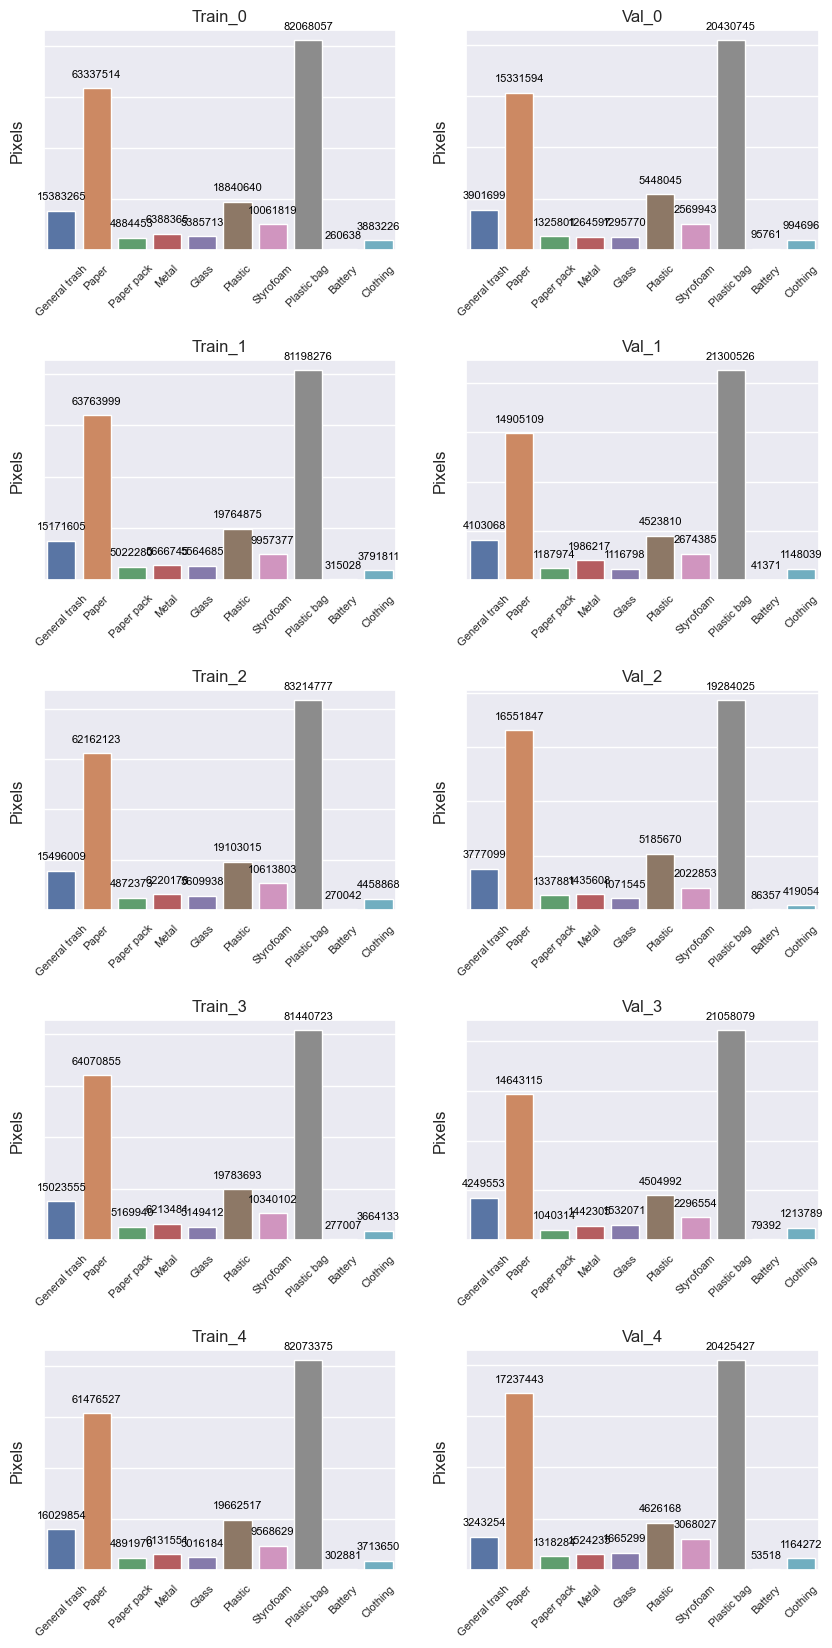

In [68]:
f, axes = plt.subplots(5,2, figsize=(10,20))
plt.subplots_adjust(hspace=0.5)

for i in range(5):
    for j in range(2):
        plt.sca(axes[i, j])
        plt.xticks(fontsize=8, rotation=45)
# 격자 크기 설정
# draw train
for i in range(5):
    sorted_dict = sorted(dic_train[i].items())
    t_pixels = []
    for t_i, pixel in sorted_dict:
        if t_i == 0:
            continue
        t_pixels.append(pixel)
    df = pd.DataFrame({'Categories':classes, 'Pixels':t_pixels})
    plot = sns.barplot(y="Pixels", x ="Categories", data=df, ax=axes[i, 0])
    plot.set(yticklabels=[], xlabel=None)
    for p in plot.patches: 
        plot.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width()/2., p.get_height() - 30), 
            ha='center', va='center', fontsize=8, color='black', xytext=(0, 10), 
            textcoords='offset points')
    axes[i,0].set_title(f'Train_{i}')
    
for i in range(5):
    sorted_dict = sorted(dic_val[i].items())
    t_pixels = []
    for t_i, pixel in sorted_dict:
        if t_i == 0:
            continue
        t_pixels.append(pixel)
    df = pd.DataFrame({'Categories':classes, 'Pixels':t_pixels})
    plot = sns.barplot(y="Pixels", x ="Categories", data=df, ax=axes[i, 1])
    plot.set(yticklabels=[], xlabel=None)
    for p in plot.patches: 
        plot.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width()/2., p.get_height() - 30), 
            ha='center', va='center', fontsize=8, color='black', xytext=(0, 10), 
            textcoords='offset points')
    axes[i,1].set_title(f'Val_{i}')



[{0: 476061446, 8: 82068057, 1: 15383265, 6: 18840640, 4: 6388365, 2: 63337514, 3: 4884453, 7: 10061819, 10: 3883226, 5: 5385713, 9: 260638}, {0: 475814167, 5: 5564685, 6: 19764875, 8: 81198276, 1: 15171605, 4: 5666745, 3: 5022280, 2: 63763999, 7: 9957377, 10: 3791811, 9: 315028}, {0: 474009722, 5: 5609938, 6: 19103015, 8: 83214777, 4: 6220178, 2: 62162123, 1: 15496009, 3: 4872373, 7: 10613803, 10: 4458868, 9: 270042}, {0: 475160091, 5: 5149412, 6: 19783693, 8: 81440723, 1: 15023555, 4: 6213481, 2: 64070855, 3: 5169940, 7: 10340102, 10: 3664133, 9: 277007}, {0: 477163710, 5: 5016184, 6: 19662517, 8: 82073375, 1: 16029854, 2: 61476527, 3: 4891970, 4: 6131551, 7: 9568629, 10: 3713650, 9: 302881}]
